<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/pinn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras import layers

print(tf.__version__)
print(keras.__version__)


In [42]:
import torch
import torch.nn as nn

class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 5)  # Output layer with 5 neurons
        )

    def forward(self, t):
        return self.net(t)


In [43]:
def ode_loss(model, t, y_true):
    y_pred = model(t)

    # Reshape y_pred and y_true to have the same shape
    y_pred = y_pred.transpose(0, 1)  # Transpose to shape (5, 3)

    # Data loss
    loss_data = torch.mean((y_pred - y_true)**2)

    # Physics loss (approximating derivatives)
    dt = 0.01
    t_prev = t - dt
    t_next = t + dt
    y_prev = model(t_prev)
    y_next = model(t_next)
    dy_dt = (y_next - y_prev) / (2 * dt)

    # Define your ODE here (example: dy/dt = -y)
    # NOTE: You may need to adjust this part to match your actual ODE
    ode_residual = dy_dt + y_pred.transpose(0, 1)  # Transpose back for physics loss calculation
    loss_physics = torch.mean(ode_residual**2)

    return loss_data + loss_physics

In [45]:
import numpy as np

# Prepare data
data = np.array([
    [0.906000416, 0.906000416, 0.906000416],
    [-0.44796003, -0.560154646, -5.091964284],
    [1.778358524, 0, 0],
    [0, 1.175149691, 0],
    [0.055374646, 0.098434984, -0.101756864]
])
t_data = torch.tensor([1, 2, 4], dtype=torch.float32).unsqueeze(1)
y_data = torch.tensor(data, dtype=torch.float32)

model = ODENet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = ode_loss(model, t_data, y_data)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 2.4126851558685303
Epoch 1000, Loss: 0.00014874956104904413
Epoch 2000, Loss: 1.2984169295293668e-08
Epoch 3000, Loss: 7.780156074943534e-09
Epoch 4000, Loss: 0.0001210949121741578
Epoch 5000, Loss: 1.0419543627904204e-07
Epoch 6000, Loss: 1.0432070496335655e-07
Epoch 7000, Loss: 7.738082103969646e-07
Epoch 8000, Loss: 1.1179724879184505e-06
Epoch 9000, Loss: 8.480400310872938e-07


In [46]:
y_data[1, :].detach().numpy()

array([-0.44796002, -0.5601546 , -5.0919642 ], dtype=float32)

(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([0.9060, 0.9060, 0.9060]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([-0.4480, -0.5602, -5.0920]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([1.7784, 0.0000, 0.0000]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([0.0000, 1.1751, 0.0000]))
(array([[1.],
       [2.],
       [4.]], dtype=float32), tensor([ 0.0554,  0.0984, -0.1018]))


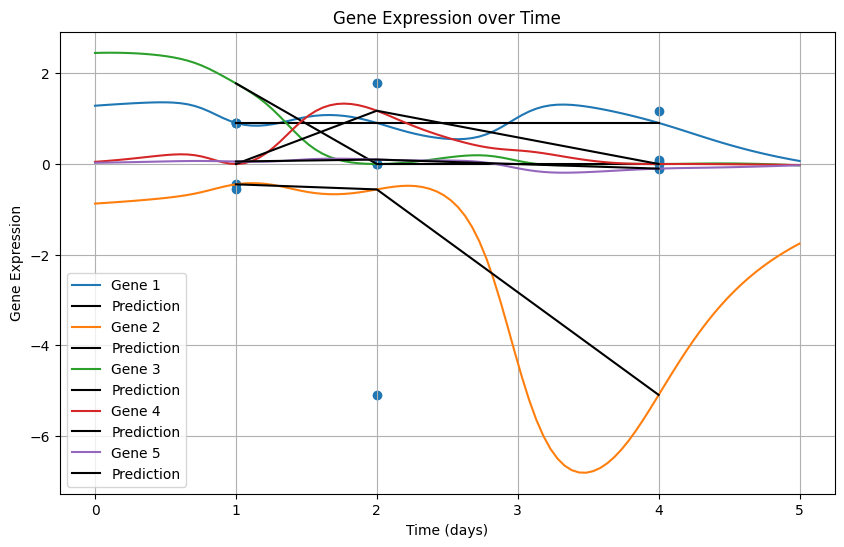

In [60]:
import matplotlib.pyplot as plt

t_plot = torch.linspace(0, 5, 100).unsqueeze(1)
y_plot = model(t_plot).detach().numpy()

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(t_plot, y_plot[:, i], label=f"Gene {i+1}")
    print((t_data.detach().numpy(), y_data[i, ]))
    plt.plot(t_data.detach().numpy(), y_data[i, ].detach().numpy(), label='Prediction', color='black')


# Repeat t_data for each gene and flatten y_data
t_scatter = np.repeat(t_data.numpy().squeeze(), y_data.shape[0])
y_scatter = y_data.numpy().flatten()
# plt.plot(t_data, y_data, label='Prediction', color='blue')


plt.scatter(t_scatter, y_scatter)  # Updated scatter plot
plt.xlabel("Time (days)")
plt.ylabel("Gene Expression")
plt.legend()
plt.title("Gene Expression over Time")
plt.grid(True)
plt.show()

In [67]:
import tensorflow as tf
import numpy as np

# Data
time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)  # Time in days
expression_values = np.array([
    [0.906000416, 0.906000416, 0.906000416],    # AT2G38470
    [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
    [1.778358524, 0, 0],                        # AT1G06930
    [0, 1.175149691, 0],                        # AT1G04470
    [0.055374646, 0.098434984, -0.101756864],   # AT5G66730
    [0.505, 0.505, 0.505],                      # AT2G38471
], dtype=np.float32)

# Number of genes
num_genes = expression_values.shape[0]

# Define the PINN model for multiple genes
class MultiGeneODE_PINN(tf.keras.Model):
    def __init__(self, num_genes):
        super(MultiGeneODE_PINN, self).__init__()
        self.num_genes = num_genes
        self.hidden_layers = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)]
        self.output_layer = tf.keras.layers.Dense(num_genes)  # Predict x(t) for all genes
        self.k = tf.Variable(tf.random.uniform([num_genes], 0.1, 1.0), trainable=True, dtype=tf.float32)  # Learnable parameters k for each gene

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Define loss function
def loss_fn(model, t, x_true):
    t = tf.convert_to_tensor(t, dtype=tf.float32)  # Ensure t is a TensorFlow tensor
    x_pred = model(t)  # Predicted x(t) for all genes

    with tf.GradientTape() as tape:
        tape.watch(t)
        x_t = model(t)  # Recompute x(t) under the tape
    dx_dt = tape.gradient(x_t, t)  # Compute dx/dt for all genes

    k = tf.expand_dims(model.k, axis=0)  # Expand dims to match batch size
    x_steady = tf.constant(expression_values[:, -1], dtype=tf.float32)  # Steady-state values from the last time point
    x_steady = tf.expand_dims(x_steady, axis=0)  # Expand dims to match batch size

    ode_residual = dx_dt + k * (x_t - x_steady)  # Residual for each gene

    # Combined loss: ODE residual + Data fitting
    return tf.reduce_mean(tf.square(ode_residual)) + tf.reduce_mean(tf.square(x_pred - x_true))

# Prepare training
model = MultiGeneODE_PINN(num_genes=num_genes)
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 300
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, time_points, expression_values.T)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Display the learned parameters k
print(f"Learned decay constants k: {model.k.numpy()}")

# Predict x(t) using the trained PINN
predicted_values = model(time_points).numpy()
print("Predicted Values:\n", predicted_values)


Epoch 0, Loss: 3.655817985534668
Epoch 50, Loss: 0.5109649896621704
Epoch 100, Loss: 0.2725704312324524
Epoch 150, Loss: 0.27027592062950134
Epoch 200, Loss: 0.2702435851097107
Epoch 250, Loss: 0.2702292799949646
Learned decay constants k: [0.6200163  0.40871054 0.55360734 0.14670047 0.8801839  0.23807615]
Predicted Values:
 [[ 1.1311463e+00 -9.3773282e-01  1.5740498e+00  6.9854185e-02
   2.3690233e-01  6.1646587e-01]
 [ 1.0807307e+00 -1.0709915e+00  1.6548538e-01  1.2087262e+00
   2.0375943e-01  5.9469903e-01]
 [ 9.0608674e-01 -5.0918689e+00  8.9593232e-05  1.0590255e-04
  -1.0162805e-01  5.0509840e-01]]


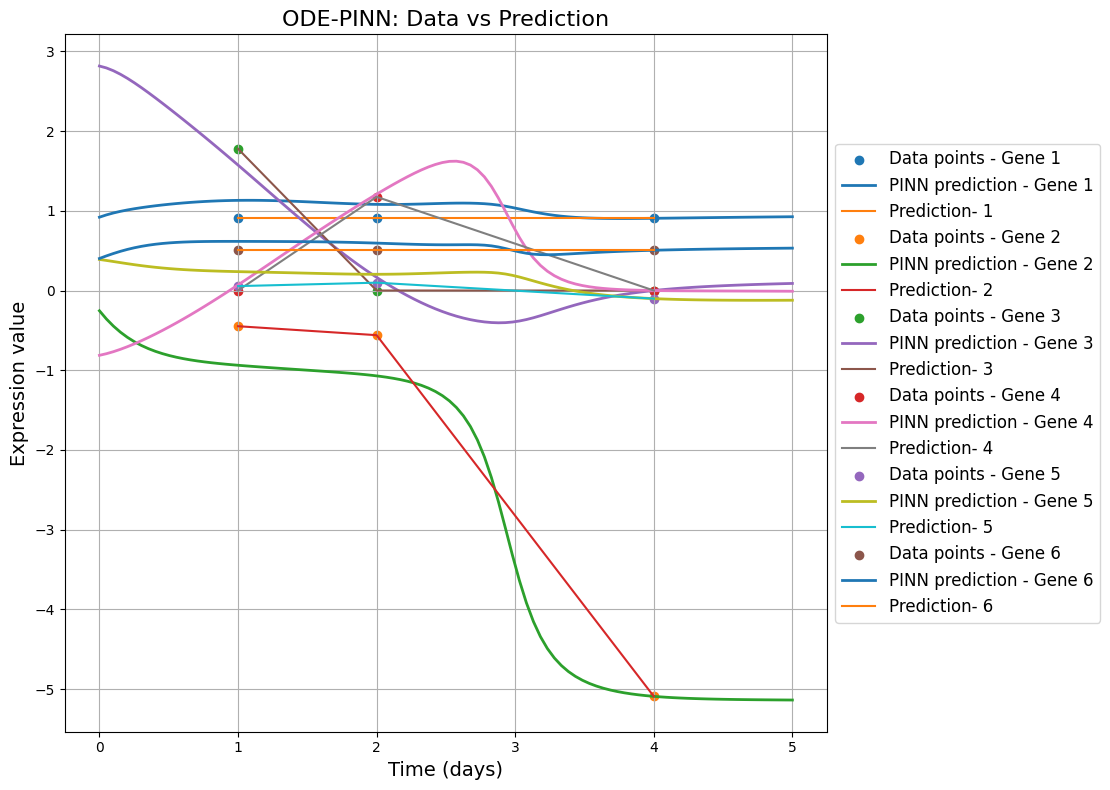

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a range of time points for a smooth curve
t_smooth = np.linspace(0, 5, 100).reshape(-1, 1)

# Get predictions for the smooth curve (replace `model` with your trained model)
x_smooth = model(t_smooth).numpy()

# Create a large figure
plt.figure(figsize=(14, 8))

# Loop through each gene and plot its data and prediction
for i in range(num_genes):
    plt.scatter(
        time_points,
        expression_values[i],
        label=f'Data points - Gene {i+1}',
        marker='o',
    )
    plt.plot(
        t_smooth,
        x_smooth[:, i],
        label=f'PINN prediction - Gene {i+1}',
        linewidth=2,
    )

    plt.plot(time_points, expression_values[i, ], label=f'Prediction- {i+1}')

# Labels, title, and grid
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Expression value', fontsize=14)
plt.title('ODE-PINN: Data vs Prediction', fontsize=16)
plt.grid(True)

# Adjust legend: Move it outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Make space for the legend on the right

# Show the plot
plt.show()


Test Predictions (Predicted):
[[ 1.1311463e+00 -9.3773282e-01  1.5740498e+00  6.9854185e-02
   2.3690233e-01  6.1646587e-01]
 [ 1.0807307e+00 -1.0709915e+00  1.6548538e-01  1.2087262e+00
   2.0375943e-01  5.9469903e-01]
 [ 9.0608674e-01 -5.0918689e+00  8.9593232e-05  1.0590255e-04
  -1.0162805e-01  5.0509840e-01]]

Test Data (Actual):
[[0.9 0.7 0. ]
 [0.5 0.7 0.5]
 [0.  0.7 0. ]]


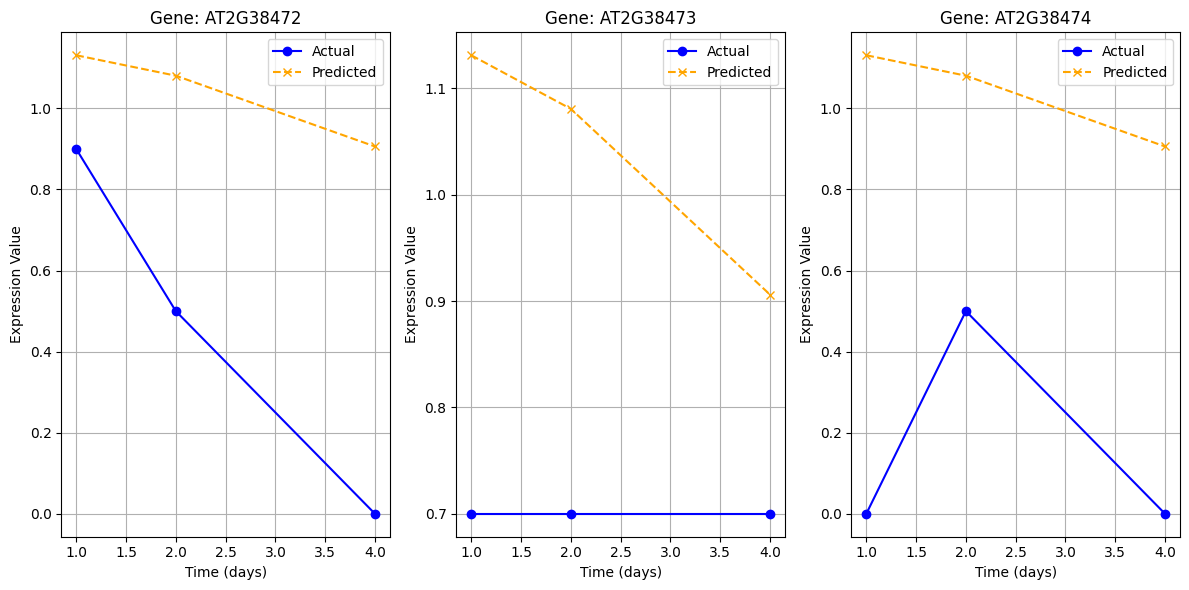

In [88]:
import matplotlib.pyplot as plt

# Test data
test_expression_values = np.array([
    [0.9, 0.5, 0.0],  # AT2G38472
    [0.7, 0.7, 0.7],  # AT2G38473
    [0.0, 0.5, 0.0],  # AT2G38474
], dtype=np.float32)

# Predict x(t) for the test data using the trained PINN
test_time_points = np.array([1, 2, 4], dtype=np.float32).reshape(-1, 1)
predicted_test_values = model(test_time_points).numpy()


# Print the test predictions
print("Test Predictions (Predicted):")
print(predicted_test_values)

print("\nTest Data (Actual):")
print(test_expression_values.T)  # Transpose for direct comparison



# Plot predictions vs. actual data
gene_labels = ["AT2G38472", "AT2G38473", "AT2G38474"]

plt.figure(figsize=(12, 6))

for i, gene in enumerate(gene_labels):
    plt.subplot(1, 3, i + 1)  # Create subplots for each gene
    plt.plot(test_time_points, test_expression_values[i], 'o-', label="Actual", color="blue")
    plt.plot(test_time_points, predicted_test_values[:, 0], 'x--', label="Predicted", color="orange")
    plt.title(f"Gene: {gene}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 0, Loss: 9.159056
Epoch 500, Loss: 0.000432
Epoch 1000, Loss: 0.000000
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 2500, Loss: 0.000003
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 4500, Loss: 0.000000
Estimated parameters:
k: -0.252321, c: -0.044388


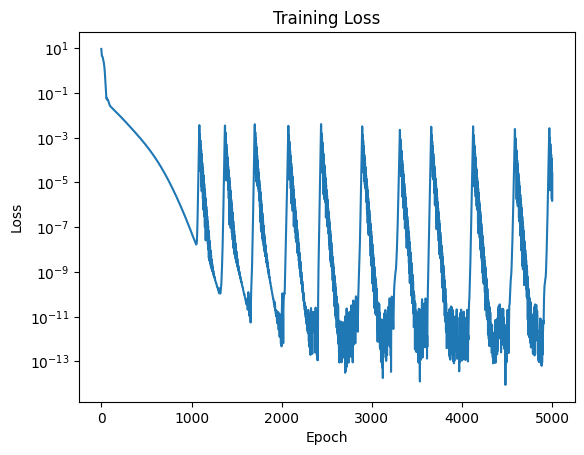

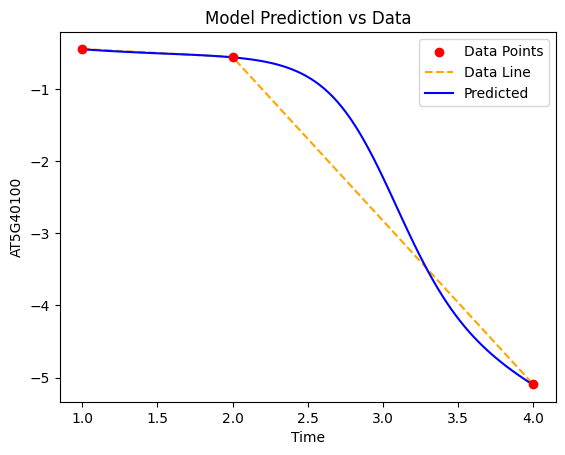

In [89]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([-0.44796, -0.56015, -5.09196], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()


Epoch 0, Loss: 0.062300
Epoch 500, Loss: 0.000002
Epoch 1000, Loss: 0.000000
Epoch 1500, Loss: 0.000000
Epoch 2000, Loss: 0.000000
Epoch 2500, Loss: 0.000000
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000000
Epoch 4000, Loss: 0.000000
Epoch 4500, Loss: 0.000000
Estimated parameters:
k: -0.362997, c: -0.148826


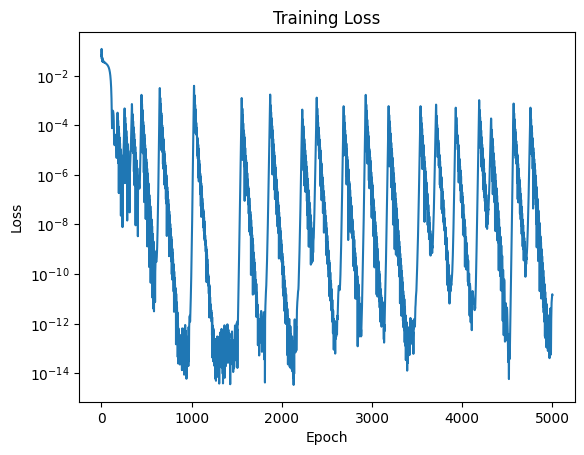

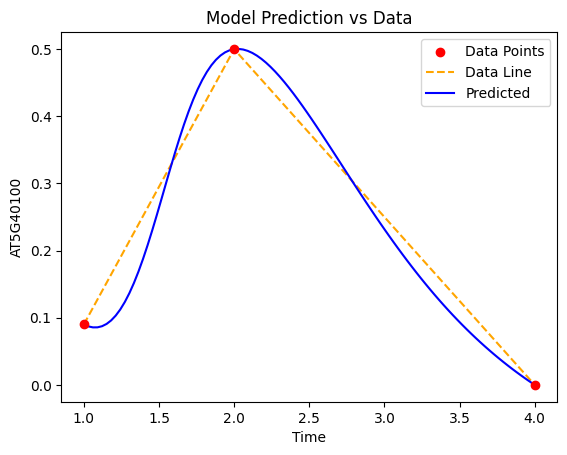

In [90]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Given data
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)
data_values = torch.tensor([.09, 0.5, 0.0], dtype=torch.float32).view(-1, 1)

# Neural Network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Parameters to estimate
        self.k = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Physics-Informed Loss Function
def loss_function(model, t, y_true):
    # Data loss
    y_pred = model(t)
    data_loss = torch.mean((y_pred - y_true) ** 2)

    # Physics loss
    # y_pred.requires_grad = True
    t = t.clone().requires_grad_(True)
    y_pred = model(t)
    dy_dt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    physics_loss = torch.mean((dy_dt + model.k * y_pred - model.c) ** 2)
    return data_loss + physics_loss

# Model, Optimizer, and Training Setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, time_points, data_values)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Results
print("Estimated parameters:")
print(f"k: {model.k.item():.6f}, c: {model.c.item():.6f}")

# Plot Loss History
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot Prediction vs Data
# Plot given data points
plt.scatter(time_points.numpy(), data_values.numpy(), label='Data Points', color='red', zorder=5)
plt.plot(time_points.numpy(), data_values.numpy(), label='Data Line', color='orange', linestyle='--')

# Plot model prediction
t_fine = torch.linspace(1, 4, 100).view(-1, 1)
y_pred_fine = model(t_fine).detach().numpy()
plt.plot(t_fine.numpy(), y_pred_fine, label='Predicted', color='blue')

plt.xlabel('Time')
plt.ylabel('AT5G40100')
plt.title('Model Prediction vs Data')
plt.legend()
plt.show()


Epoch 0, Loss: 10.683965682983398
Epoch 1000, Loss: 5.4812569278339315e-14
Epoch 2000, Loss: 4.910339170861866e-13
Epoch 3000, Loss: 0.0018258841009810567
Epoch 4000, Loss: 0.0034338999539613724
Epoch 5000, Loss: 0.0005319385672919452
Epoch 6000, Loss: 3.641277362476103e-05
Epoch 7000, Loss: 7.943305035951198e-07
Epoch 8000, Loss: 7.6032415563531686e-06
Epoch 9000, Loss: 8.151381916832179e-05
Learned k_p1: 0.6428403854370117
Learned k_d1: 0.7056630253791809
Learned k_d2: 3.742082844837569e-05


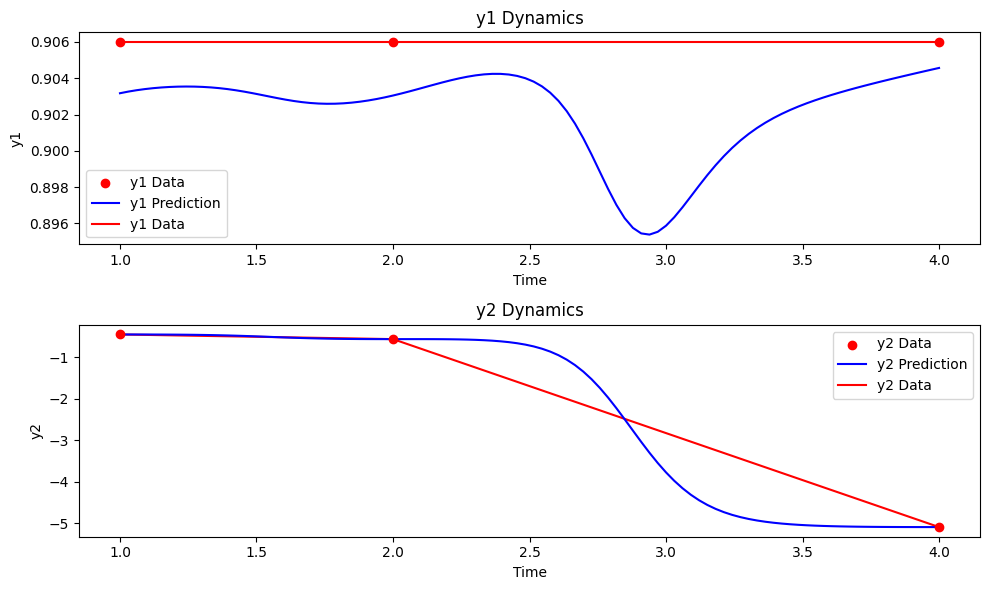

In [91]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)  # Outputs: y1, y2
        )
        # Trainable parameters
        self.k_p1 = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d1 = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y1_pred, y2_pred = y_pred[:, 0], y_pred[:, 1]

    # Compute derivatives
    y1_t = torch.autograd.grad(y1_pred, t, grad_outputs=torch.ones_like(y1_pred), create_graph=True)[0]
    y2_t = torch.autograd.grad(y2_pred, t, grad_outputs=torch.ones_like(y2_pred), create_graph=True)[0]

    # ODE residuals
    ode1 = y1_t - (model.k_p1 - model.k_d1 * y1_pred)
    ode2 = y2_t + model.k_d2 * y2_pred

    # Physics loss
    physics_loss = torch.mean(ode1**2) + torch.mean(ode2**2)

    # Data loss
    data_loss = torch.mean((y1_pred - y_data[:, 0])**2) + torch.mean((y2_pred - y_data[:, 1])**2)

    return data_loss + 1.0 * physics_loss

# Generate data
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
y_data = torch.tensor([[0.906, -0.44796], [0.906, -0.56015], [0.906, -5.09196]])

# Initialize model and optimizer
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output learned parameters
print(f"Learned k_p1: {model.k_p1.item()}")
print(f"Learned k_d1: {model.k_d1.item()}")
print(f"Learned k_d2: {model.k_d2.item()}")

# Generate predictions for plotting
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

# Plotting the results
plt.figure(figsize=(10, 6))

# y1 Plot
plt.subplot(2, 1, 1)
plt.scatter(t_data.detach().numpy(), y_data[:, 0], color='red', label='y1 Data', zorder=5)
plt.plot(t_test.detach().numpy(), y_pred[:, 0], label='y1 Prediction', color='blue', zorder=4)
plt.plot(t_data.detach().numpy(), y_data[:, 0], label='y1 Data', color='red')
plt.title('y1 Dynamics')
plt.xlabel('Time')
plt.ylabel('y1')
plt.legend()

# y2 Plot
plt.subplot(2, 1, 2)
plt.scatter(t_data.detach().numpy(), y_data[:, 1], color='red', label='y2 Data', zorder=5)
plt.plot(t_test.detach().numpy(), y_pred[:, 1], label='y2 Prediction', color='blue', zorder=4)
plt.plot(t_data.detach().numpy(), y_data[:, 1], label='y2 Data', color='red')
plt.title('y2 Dynamics')
plt.xlabel('Time')
plt.ylabel('y2')
plt.legend()

plt.tight_layout()
plt.show()


Training for AT2G3847...
AT2G3847: Epoch 0, Loss: 1.6567437648773193
AT2G3847: Epoch 100, Loss: 0.0005416607018560171
AT2G3847: Epoch 200, Loss: 1.6220812540268525e-05
AT2G3847: Epoch 300, Loss: 2.7876826607098337e-06
AT2G3847: Epoch 400, Loss: 1.7300258150498848e-06
AT2G3847: Epoch 500, Loss: 1.5537906392637524e-06
AT2G3847: Epoch 600, Loss: 1.4556480891769752e-06
AT2G3847: Epoch 700, Loss: 1.3610383575723972e-06
AT2G3847: Epoch 800, Loss: 1.2661564596783137e-06
AT2G3847: Epoch 900, Loss: 1.1722692079274566e-06
AT2G3847: Learned k_p = 0.9090627431869507, k_d = 1.0035465955734253
Training for AT5G4010...
AT5G4010: Epoch 0, Loss: 9.80221176147461
AT5G4010: Epoch 100, Loss: 0.04552246630191803
AT5G4010: Epoch 200, Loss: 0.002068274188786745
AT5G4010: Epoch 300, Loss: 4.107274875764233e-08
AT5G4010: Epoch 400, Loss: 1.6768808563938364e-12
AT5G4010: Epoch 500, Loss: 4.144832484095093e-15
AT5G4010: Epoch 600, Loss: 1.1842379282265398e-15
AT5G4010: Epoch 700, Loss: 6.217248937900877e-15
AT5G

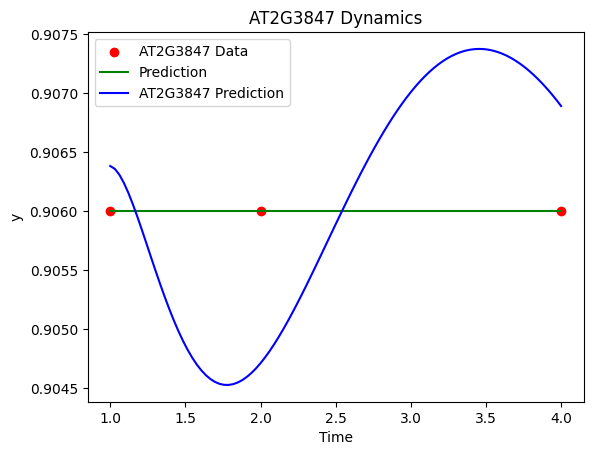

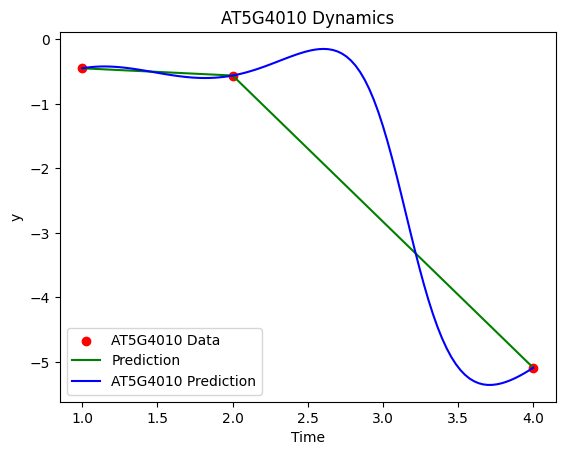

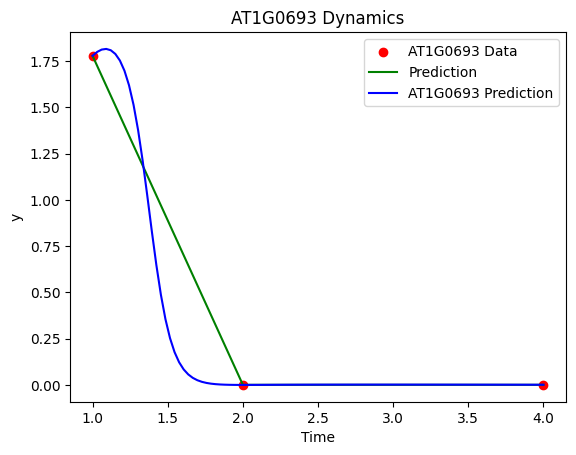

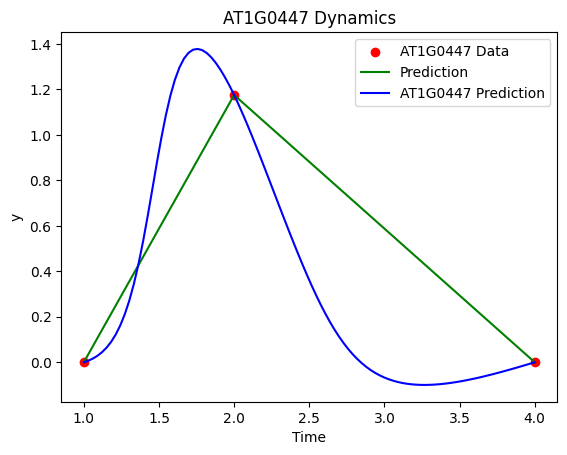

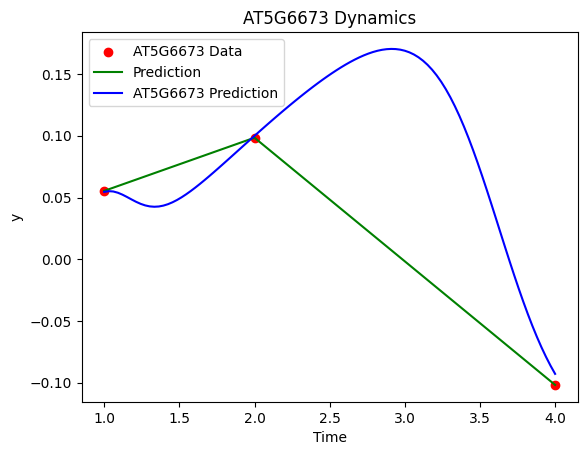

In [92]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Trainable parameters for the ODE
        self.k_p = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.k_d = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data, ode_type="linear"):
    y_pred = model(t)
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    if ode_type == "linear":
        ode_residual = y_t - (model.k_p - model.k_d * y_pred)
    elif ode_type == "quadratic":
        ode_residual = y_t - model.k_p * y_pred**2
    elif ode_type == "sinusoidal":
        ode_residual = y_t - (model.k_p + model.k_d * torch.sin(y_pred))
    else:
        raise ValueError("Unsupported ODE type!")

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data preprocessing
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
dataset = {
    "AT2G3847": torch.tensor([0.906, 0.906, 0.906]),
    "AT5G4010": torch.tensor([-0.44796, -0.56015, -5.09196]),
    "AT1G0693": torch.tensor([1.778359, 0, 0]),
    "AT1G0447": torch.tensor([0, 1.17515, 0]),
    "AT5G6673": torch.tensor([0.055375, 0.098435, -0.101757])
}

ode_types = {
    "AT2G3847": "linear",
    "AT5G4010": "linear",
    "AT1G0693": "quadratic",
    "AT1G0447": "linear",
    "AT5G6673": "sinusoidal"
}

# Train models for each feature
models = {}
for feature, y_data in dataset.items():
    print(f"Training for {feature}...")
    y_data = y_data.view(-1, 1)  # Reshape data
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(1000):
        optimizer.zero_grad()
        loss = loss_fn(model, t_data, y_data, ode_types[feature])
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"{feature}: Epoch {epoch}, Loss: {loss.item()}")

    # Store the trained model
    models[feature] = model
    print(f"{feature}: Learned k_p = {model.k_p.item()}, k_d = {model.k_d.item()}")

# Plotting the results
for feature, y_data in dataset.items():
    model = models[feature]
    t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    y_pred = model(t_test).detach().numpy()

    plt.figure()
    plt.scatter(t_data.detach().numpy(), y_data.numpy(), color='red', label=f'{feature} Data')
    plt.plot(t_data.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green')

    plt.plot(t_test.detach().numpy(), y_pred, label=f'{feature} Prediction', color='blue')

    plt.title(f'{feature} Dynamics')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()


Epoch 0, Loss: 10.481283187866211
Epoch 100, Loss: 0.023170465603470802
Epoch 200, Loss: 0.04048049449920654
Epoch 300, Loss: 0.0004936137120239437
Epoch 400, Loss: 7.294766419363441e-06
Epoch 500, Loss: 2.1168187231523916e-05
Epoch 600, Loss: 3.566530182297356e-09
Epoch 700, Loss: 1.0510111525660268e-13
Epoch 800, Loss: 1.1340631558831582e-11
Epoch 900, Loss: 5.505244697612266e-12
Learned k_p: 0.5219053030014038
Learned k_d: 0.7671692967414856


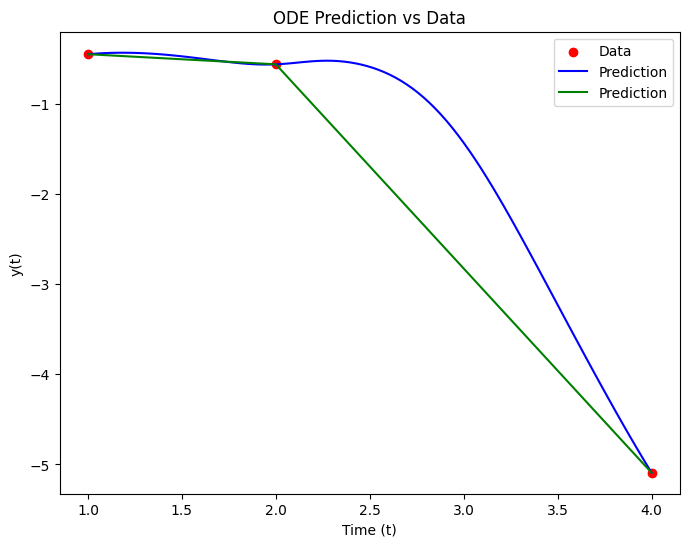

In [94]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Trainable parameters for the ODE
        self.k_p = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Forcing term
        self.k_d = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Decay/growth rate

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # ODE residual
    ode_residual = y_t - (model.k_p + model.k_d * y_pred)

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data preprocessing
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # Time points
y_data = torch.tensor([[-0.44796], [-0.56015], [-5.09196]])      # Corresponding values

# Initialize the model and optimizer
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output the learned parameters
print(f"Learned k_p: {model.k_p.item()}")
print(f"Learned k_d: {model.k_d.item()}")

# Plotting the data and the prediction
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(t_data.detach().numpy(), y_data.numpy(), color='red', label='Data')
plt.plot(t_test.detach().numpy(), y_pred, label='Prediction', color='blue')
plt.plot(t_data.detach().numpy(), y_data.detach().numpy(), label='Prediction', color='green')


plt.title('ODE Prediction vs Data')
plt.xlabel('Time (t)')
plt.ylabel('y(t)')
plt.legend()
plt.show()


Epoch 0, Loss: 22.543996810913086
Epoch 1000, Loss: 0.0037486504297703505
Epoch 2000, Loss: 0.000415901216911152
Epoch 3000, Loss: 3.054362878174288e-06
Epoch 4000, Loss: 0.000179002876393497
Epoch 5000, Loss: 0.00046172516886144876
Epoch 6000, Loss: 0.0003813082876149565
Epoch 7000, Loss: 0.00021866918541491032
Epoch 8000, Loss: 9.587818203726783e-05
Epoch 9000, Loss: 3.06460824504029e-05
ODE 1: Learned k_p: 0.054462287575006485, Learned k_d: 2.7021731511922553e-05
ODE 2: Learned k_p: 0.06263802200555801, Learned k_d: -7.380777969956398e-05
ODE 3: Learned k_p: 0.07550284266471863, Learned k_d: 0.0001586509752087295
ODE 4: Learned k_p: 0.056437887251377106, Learned k_d: 0.0011109481565654278
ODE 5: Learned k_p: 0.06916230171918869, Learned k_d: 0.02632945403456688
ODE 6: Learned k_p: 0.041984401643276215, Learned k_d: 0.0003978064050897956
ODE 7: Learned k_p: 0.09044738858938217, Learned k_d: 0.004989172797650099
ODE 8: Learned k_p: 0.05959561839699745, Learned k_d: -2.8830316296080127

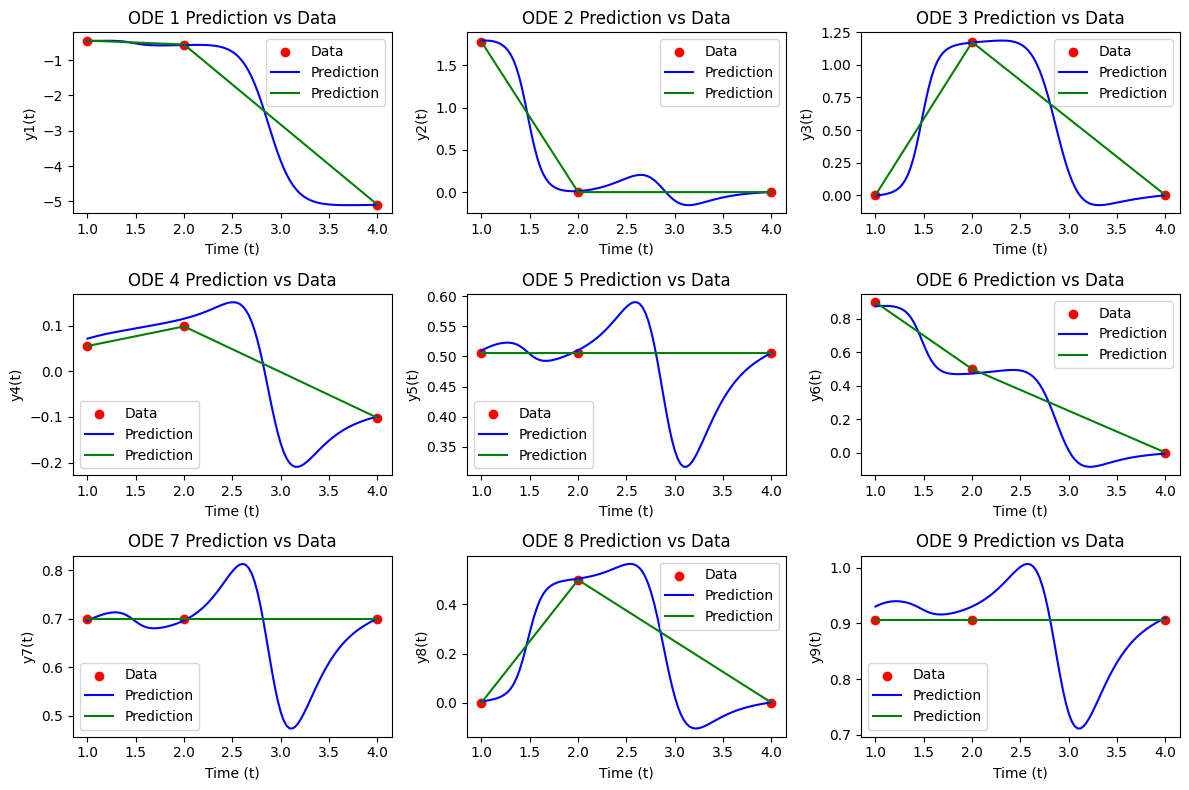

In [103]:
# import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, num_odes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, num_odes)  # Output: y(t) for each ODE
        )
        # Trainable parameters for each ODE
        self.k_p = nn.Parameter(torch.ones(num_odes))  # Forcing terms
        self.k_d = nn.Parameter(torch.ones(num_odes))  # Decay/growth rates

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t)  # Predicted outputs (all ODEs)
    num_odes = y_data.shape[1]

    # Compute derivatives and ODE residuals
    losses = []
    for i in range(num_odes):
        y_i_pred = y_pred[:, i]
        y_i_t = torch.autograd.grad(
            y_i_pred, t, grad_outputs=torch.ones_like(y_i_pred), create_graph=True
        )[0]
        # ODE residual for the i-th ODE
        ode_residual = y_i_t - (model.k_p[i] + model.k_d[i] * y_i_pred)

        # Physics loss
        physics_loss = torch.mean(ode_residual**2)

        # Data loss
        data_loss = torch.mean((y_i_pred - y_data[:, i])**2)

        # Total loss for the i-th ODE
        losses.append(data_loss + 1.0 * physics_loss)

    # Sum losses for all ODEs
    return sum(losses)

# Data preprocessing
# Define time points (t_data) and the data matrix (y_data)
t_data = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # Time points
y_data = torch.tensor([
    [-0.44796, -0.56015, -5.09196],
    [1.77836, 0.0, 0.0],
    [0.0, 1.17515, 0.0],
    [0.05537, 0.09843, -0.10176],
    [0.505, 0.505, 0.505],
    [0.9, 0.5, 0.0],
    [0.7, 0.7, 0.7],
    [0.0, 0.5, 0.0],
    [0.906, 0.906, 0.906]
]).T  # Transpose to have columns for ODEs

# Initialize the model and optimizer
num_odes = y_data.shape[1]
model = NeuralNet(num_odes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn(model, t_data, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Output the learned parameters
for i in range(num_odes):
    print(f"ODE {i+1}: Learned k_p: {model.k_p[i].item()}, Learned k_d: {model.k_d[i].item()}")

# Plotting the data and the prediction for each ODE
t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
y_pred = model(t_test).detach().numpy()

plt.figure(figsize=(12, 8))
for i in range(num_odes):
    plt.subplot(3, 3, i+1)  # Create a subplot for each ODE
    plt.scatter(t_data.detach().numpy(), y_data[:, i].numpy(), color='red', label='Data')
    plt.plot(t_test.detach().numpy(), y_pred[:, i], label='Prediction', color='blue')
    plt.plot(t_data.detach().numpy(), y_data[:, i], label='Prediction', color='green')

    plt.title(f'ODE {i+1} Prediction vs Data')
    plt.xlabel('Time (t)')
    plt.ylabel(f'y{i+1}(t)')
    plt.legend()

plt.tight_layout()
plt.show()


AT5G40100 - Epoch 0, Loss: 9.660833358764648
AT5G40100 - Epoch 1000, Loss: 5.112626240588725e-06
AT5G40100 - Epoch 2000, Loss: 0.000106924278952647
AT5G40100 - Epoch 3000, Loss: 0.00011599654681049287
AT5G40100 - Epoch 4000, Loss: 1.5070218069013208e-06


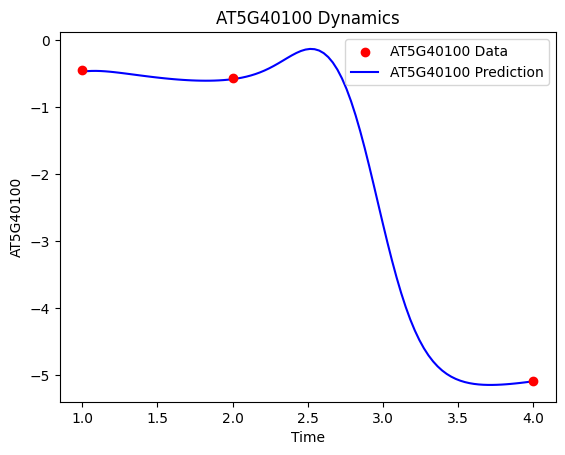

AT1G06930 - Epoch 0, Loss: 2.312055826187134
AT1G06930 - Epoch 1000, Loss: 8.74285355223492e-09
AT1G06930 - Epoch 2000, Loss: 1.1502431290972594e-14
AT1G06930 - Epoch 3000, Loss: 2.964821530643258e-12
AT1G06930 - Epoch 4000, Loss: 1.6678844449221492e-13


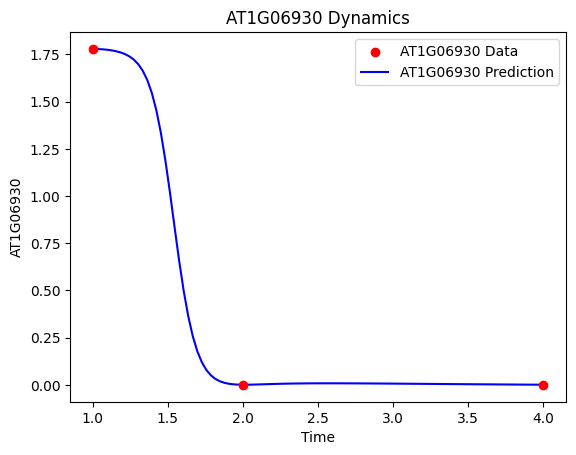

AT1G04470 - Epoch 0, Loss: 1.640841007232666
AT1G04470 - Epoch 1000, Loss: 3.2698556319196714e-13
AT1G04470 - Epoch 2000, Loss: 3.225745747446364e-14
AT1G04470 - Epoch 3000, Loss: 6.8642372669691816e-15
AT1G04470 - Epoch 4000, Loss: 1.113211146730464e-05


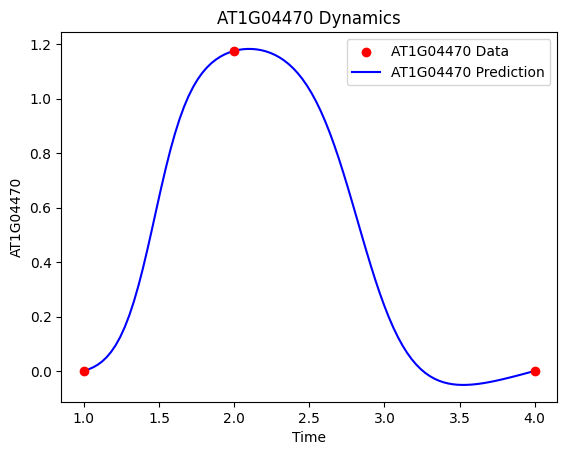

AT5G66730 - Epoch 0, Loss: 0.5569005608558655
AT5G66730 - Epoch 1000, Loss: 0.004471289925277233
AT5G66730 - Epoch 2000, Loss: 0.00031232237233780324
AT5G66730 - Epoch 3000, Loss: 1.2841128160800963e-10
AT5G66730 - Epoch 4000, Loss: 1.3079815008865125e-14


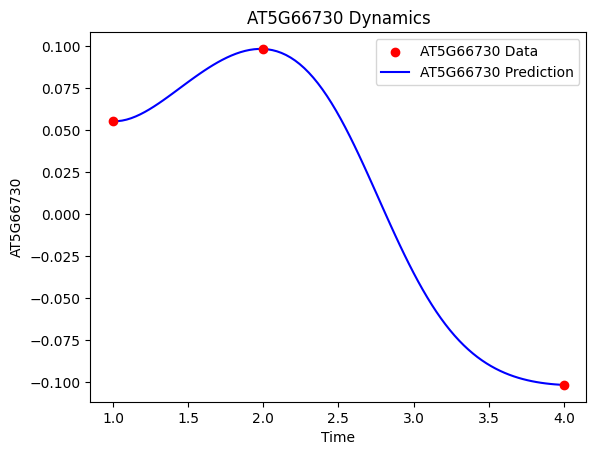

AT2G38471 - Epoch 0, Loss: 0.19915741682052612
AT2G38471 - Epoch 1000, Loss: 3.0050305355189266e-08
AT2G38471 - Epoch 2000, Loss: 9.566138103878075e-09
AT2G38471 - Epoch 3000, Loss: 1.3711958235518296e-09
AT2G38471 - Epoch 4000, Loss: 1.212499434188885e-08


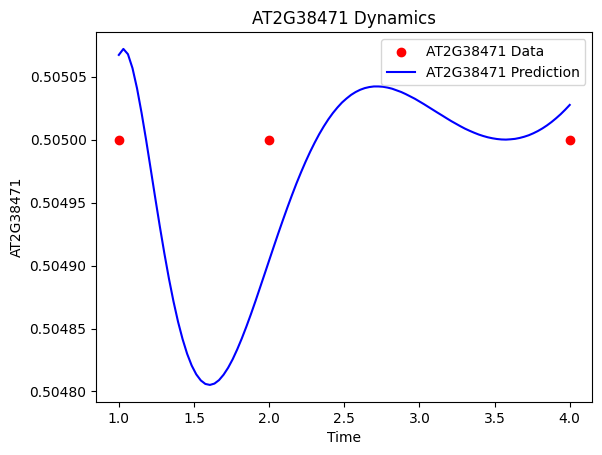

AT2G38472 - Epoch 0, Loss: 3.7023508548736572
AT2G38472 - Epoch 1000, Loss: 3.071801981616856e-13
AT2G38472 - Epoch 2000, Loss: 1.4988010832439613e-15
AT2G38472 - Epoch 3000, Loss: 3.3491727203664766e-15
AT2G38472 - Epoch 4000, Loss: 2.6540496688397253e-14


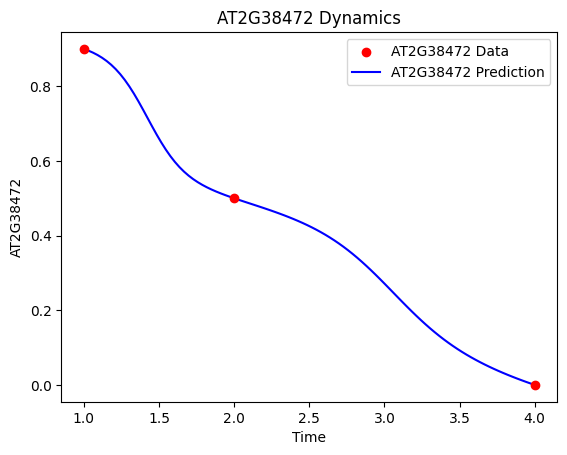

AT2G38473 - Epoch 0, Loss: 0.8571078181266785
AT2G38473 - Epoch 1000, Loss: 8.331198841915466e-09
AT2G38473 - Epoch 2000, Loss: 3.624711364391686e-10
AT2G38473 - Epoch 3000, Loss: 1.0681686646307753e-08
AT2G38473 - Epoch 4000, Loss: 1.5045765744403639e-09


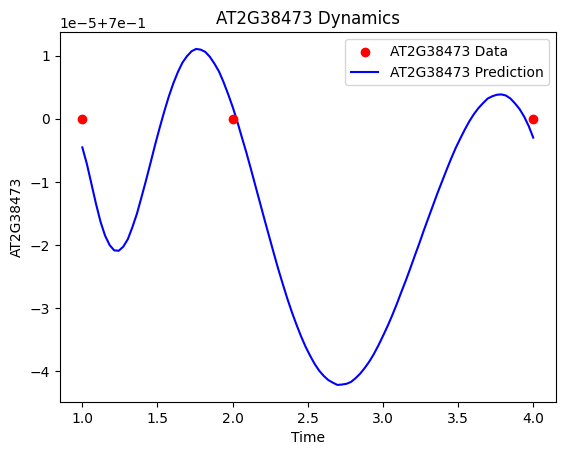

AT2G38474 - Epoch 0, Loss: 0.7640045881271362
AT2G38474 - Epoch 1000, Loss: 4.112950431622853e-12
AT2G38474 - Epoch 2000, Loss: 4.9386418619987854e-14
AT2G38474 - Epoch 3000, Loss: 1.8503717628539684e-17
AT2G38474 - Epoch 4000, Loss: 9.18709552877317e-15


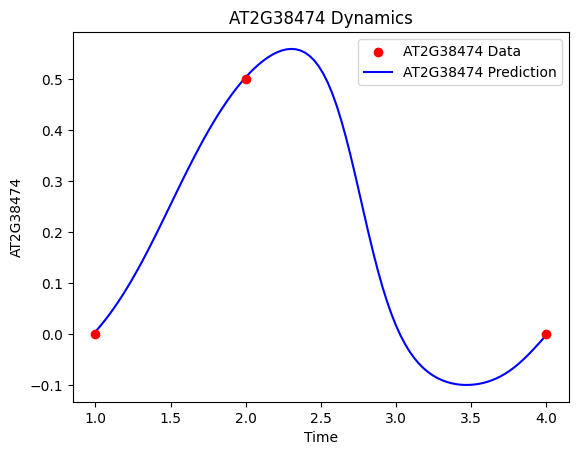

AT2G38470 - Epoch 0, Loss: 2.672614812850952
AT2G38470 - Epoch 1000, Loss: 3.4895916201094224e-07
AT2G38470 - Epoch 2000, Loss: 2.486958972092168e-10
AT2G38470 - Epoch 3000, Loss: 1.3381888641899459e-13
AT2G38470 - Epoch 4000, Loss: 2.0155135871391394e-07


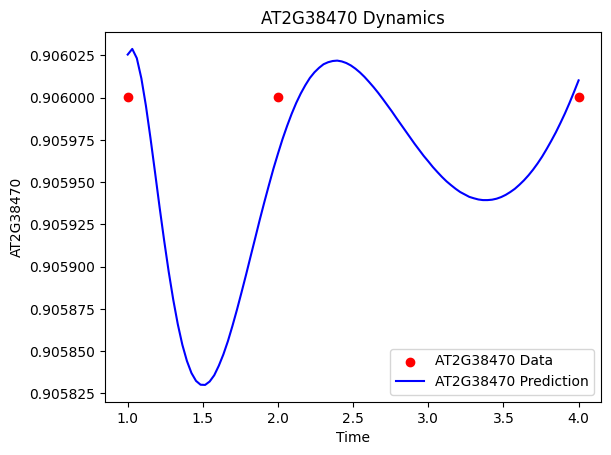

AT5G40100: k = -0.000050, c = 0.296592
AT1G06930: k = 0.000021, c = -0.005014
AT1G04470: k = -0.000001, c = 0.149265
AT5G66730: k = -0.000001, c = -0.003989
AT2G38471: k = 1.141841, c = 0.576903
AT2G38472: k = 0.000000, c = -0.137866
AT2G38473: k = 1.071019, c = 0.749645
AT2G38474: k = -0.000287, c = 0.330595
AT2G38470: k = 0.945055, c = 0.856491


In [102]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Single output: y
        )
        # Trainable parameters
        self.k = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    y_pred = model(t).squeeze()

    # Compute derivatives
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    # ODE residuals
    ode_residual = y_t + model.k * y_pred - model.c

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss

# Data: Replace with the given dataset
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points
time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)

# Initialize results
results = {}

for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)

    # Initialize model and optimizer
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(5000):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item()}")

    # Save the learned parameters
    results[gene] = {
        "k": model.k.item(),
        "c": model.c.item()
    }

    # Generate predictions for plotting
    t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    y_pred = model(t_test).detach().numpy()

    # Plotting the results
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print results
for gene, params in results.items():
    print(f"{gene}: k = {params['k']:.6f}, c = {params['c']:.6f}")
